In [23]:
# imported dependencies
import pennylane as qml
from itertools import product
import numpy as np
import random
from collections import defaultdict

In [4]:
# n = 5 (Physical Qubits)
# k = 3 (Logical Qubits)

def generate_density_matrix():
    c1 = 1/np.sqrt(2)
    c2 = 1/np.sqrt(2)
    state = np.array([c1, 0, 0, 0, 0, 0, 0, c2])
    rho = np.outer(state, np.conj(state).T)
    return rho

In [26]:
# Our generators
def generators():
    # create all generators that satisfy the requirement
    G1 = qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
    G2 = qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2)

    G1 = G1.matrix()
    G2 = G2.matrix()
    return [G1, G2]

# Our stabilizers
def stabilizers():
    G1, G2 = generators()
    I = qml.Identity(0) @ qml.Identity(1) @ qml.Identity(2)
    I = I.matrix()
    return [G1, G2, G1 @ G2, I]

# Generates our codespace
def find_unique_eigenstates(stabilizers):
    eigenvectors = defaultdict(set)
    for i,stabilizer in enumerate(stabilizers):
        eigvals, eigvecs = np.linalg.eig(stabilizer)
        for j in range(len(eigvals)):
            if np.isclose(eigvals[j], 1):
                eigenvectors[i].add(tuple(eigvecs[:,j]))

    sets_of_arrays = list(eigenvectors.values())
    common_arrays = set.intersection(*sets_of_arrays)
    return common_arrays

G = generators()
S = stabilizers()
eigenstate = find_unique_eigenstates(S)
print(eigenstate)

{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)}


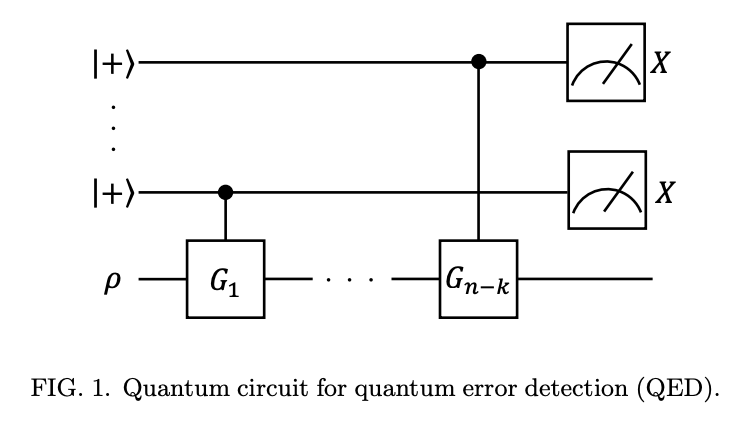

In [35]:
dev = qml.device("default.mixed", wires=5,shots=1)
@qml.qnode(dev)
def syndrome_measurement(density_matrix, generators, estimation_wires,target_wires):
    
    # should be a density matrix
    qml.QubitDensityMatrix(density_matrix, wires=target_wires)
    
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)
    
    # Introduce Bit Error
    qml.BitFlip(0.75,target_wires[0])

    for i,generator in enumerate(generators):
        qml.ControlledQubitUnitary(generator, control_wires=estimation_wires[i], wires=target_wires)
    
    measurements = []
    for wire in estimation_wires:
        measurements.append(qml.expval(qml.PauliX(wire)))
    return measurements

In [36]:
# Here rho is the ideal starting state with no noise applied
estimation_wires = [0,1]
target_wires = [2,3,4]
rho = generate_density_matrix()
print(syndrome_measurement(rho,generators(),estimation_wires,target_wires))
print(qml.draw(syndrome_measurement)(rho,generators(),estimation_wires,target_wires))

[ 1. -1.]
0: ──H─────────────────────────────────────╭●────────────┤  <X>
1: ──H─────────────────────────────────────│──────╭●─────┤  <X>
2: ─╭QubitDensityMatrix(M0)──BitFlip(0.75)─├U(M1)─├U(M2)─┤     
3: ─├QubitDensityMatrix(M0)────────────────├U(M1)─├U(M2)─┤     
4: ─╰QubitDensityMatrix(M0)────────────────╰U(M1)─╰U(M2)─┤     


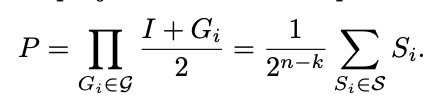

In [21]:
G1 = qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
G2 = qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2)

G1 = G1.matrix()
G2 = G2.matrix()

# S size of 4 (Assuming generators that we chose should be able to make up the set of S)
I = qml.Identity(0) @ qml.Identity(1) @ qml.Identity(2)
I = I.matrix()

G = [G1, G2]
S = [G1, G2, G1 @ G2, I]


# Assume all G are same size
def calculate_P_with_G(G):
    # G1 and G2 are diagonal matrix so the eigenvalues are just the values of the diagonal
    # Furthermore, the values are only +/- 1
    # If we add the identity matrix then the eigenvalues become 0 and 2
    # If we divide by 2 all eigenvalues become only 0 or 1
    I = np.eye(G[0].shape[0])
    P = np.eye(G[0].shape[0])
    for g in G:
        P = P @ (I + g)/2
    return P

def calculate_P_with_S(S):
    P = np.zeros(S[0].shape)
    for elem in S:
        P += elem
    # Same reasoning above, have to divide to get eigenvalue back to 0 or 1 
    P *= 1/(len(S))
    return P
        
P1 = calculate_P_with_G(G)
P2 = calculate_P_with_S(S)
print(np.allclose(P1,P2))

True


In [ ]:
def find_unique_eigenstates(stabilizers):
    eigenvectors = defaultdict(set)
    for i,stabilizer in enumerate(stabilizers):
        eigvals, eigvecs = np.linalg.eig(stabilizer)
        for j in range(len(eigvals)):
            if np.isclose(eigvals[j], 1):
                eigenvectors[i].add(tuple(eigvecs[:,j]))

    sets_of_arrays = list(eigenvectors.values())
    common_arrays = set.intersection(*sets_of_arrays)
    return common_arrays

a = find_unique_eigenstates(S)
print(a)

In [47]:
print("rho (with noise)")
print(rho_with_noise)

rho (with noise)
[[0.125+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.125+0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.375+0.j 0.375+0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.375+0.j 0.375+0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.125+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.125+0.j]]


In [48]:
print("rho_det")
print(rho_det)


rho_det
[[0.5 0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.  0.5]]


In [49]:
print(np.allclose(rho_id,rho_det))

True
